In [1]:
import numpy as np
import einops
import matplotlib.pyplot as plt
import torch
from torch import optim
from scipy.ndimage import gaussian_filter
import tqdm

from shadowgraph_linear import integrate_z_operator, grad_2_x_operator, grad_2_y_operator, ind_to_3d

In [2]:
# Assemble matrices

I0 = 1
c = -1
dx, dy, dz = 1, 1, 1
Nx, Ny, Nz = 32, 32, 32

A_intz = integrate_z_operator(Nx, Ny, Nz)
A_gradx = grad_2_x_operator(Nx, Ny, Nz, dx)
A_grady = grad_2_y_operator(Nx, Ny, Nz, dy)
A = A_intz @ (A_gradx + A_grady) # Matrix multiplication is O(n^3), this scales extremely badly (should be using sparse matrix class for optimal implementation)

assert A.shape == (Nx * Ny, Nx * Ny * Nz)  
print('A shape:', A.shape)

A shape: (1024, 32768)


In [3]:

def construct_spherical_shock(Nx, Ny, Nz, R, n_inside, n_outside, smoothed: bool = False):
    """Construct a 3D spherical shock with radius R
    """
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    z = np.linspace(-1, 1, Nz)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    arr = n_outside + n_inside * (np.sqrt(X ** 2 + Y ** 2 + Z ** 2) < R)

    if smoothed:
        # Apply a 3D Gaussian smoothing kernel
        arr = gaussian_filter(arr, sigma=1)

    return arr


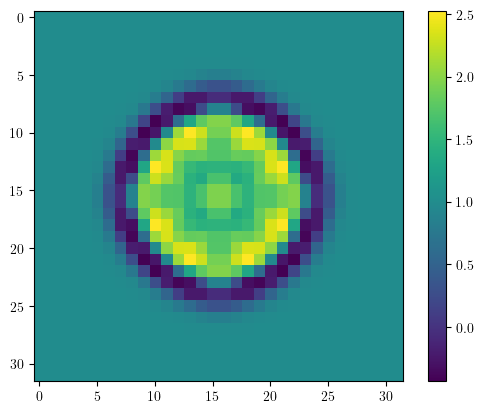

In [4]:
spherical_shock_vol = construct_spherical_shock(Nx, Ny, Nz, 0.5, 0.9, 1.1, smoothed=True)
spherical_shock_vec = einops.rearrange(spherical_shock_vol, 'i j k -> (i j k)')
shadow_vec = I0 + c * A @ spherical_shock_vec
shadow_im = einops.rearrange(shadow_vec, '(Nx Ny) -> Nx Ny', Nx=Nx, Ny=Ny)
im = plt.imshow(shadow_im)
plt.colorbar(im)

In [5]:

def slice_plot(vol: np.array) -> None:
    """Write a 3-panel slice plot of a 3D volume
    """
    assert len(vol.shape) == 3
    assert vol.shape[0] == vol.shape[1] == vol.shape[2]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    nx, ny, nz = vol.shape
    im = axs[0].imshow(vol[nx // 2, :, :])
    fig.colorbar(im, ax=axs[0])

    im = axs[1].imshow(vol[:, ny // 2, :])
    fig.colorbar(im, ax=axs[1])

    im = axs[2].imshow(vol[:, :, nz // 2])
    fig.colorbar(im, ax=axs[2])

    plt.tight_layout()
    plt.show()

Optimizing: 100%|██████████| 250/250 [00:02<00:00, 94.89it/s] 


Final loss: 141.63899124149674


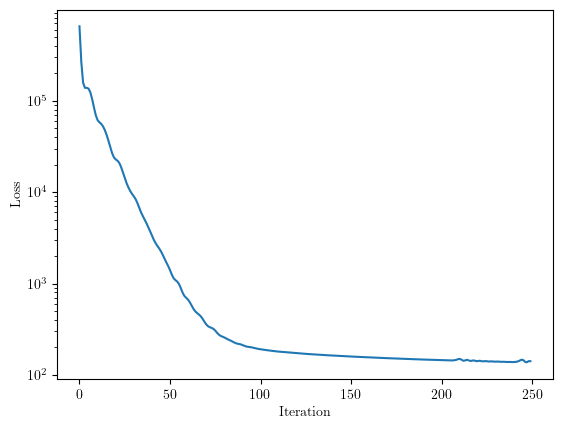

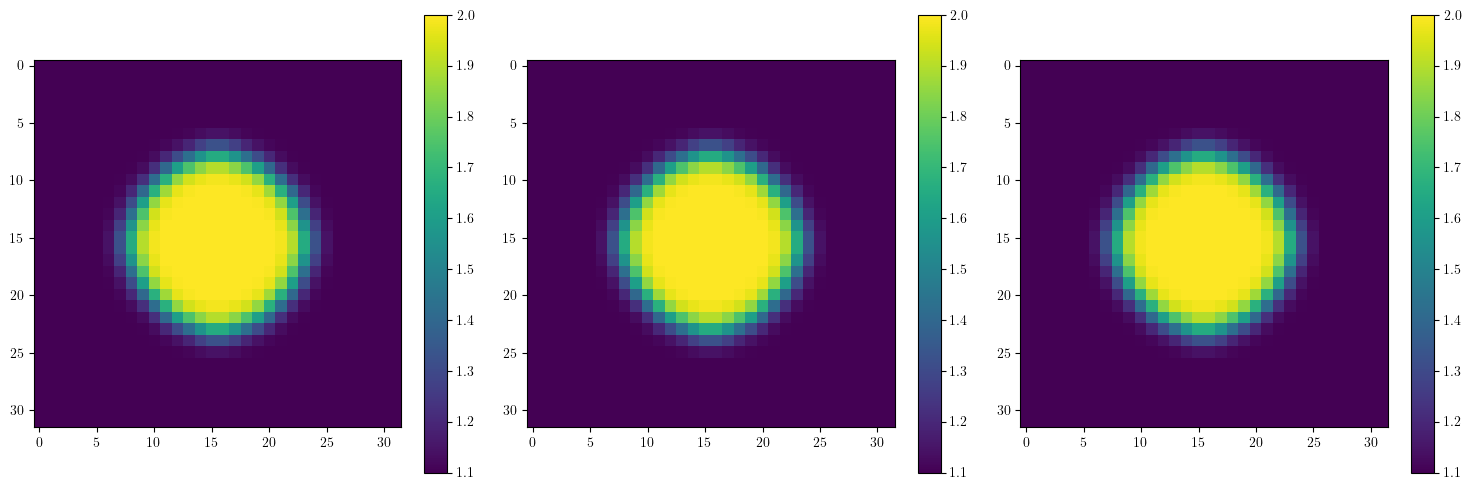

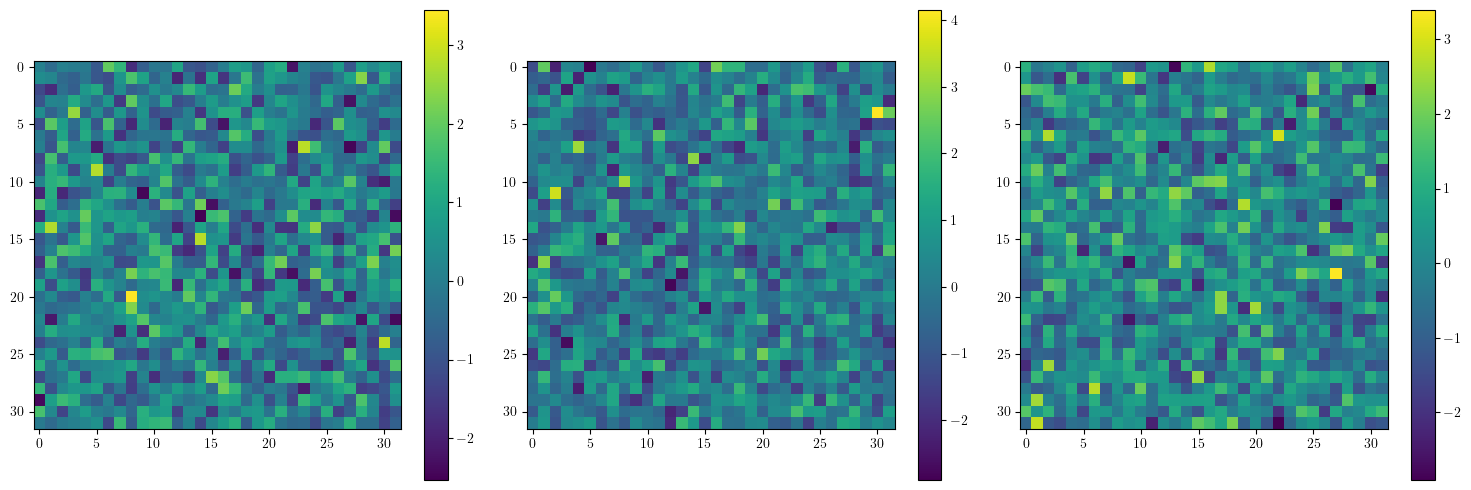

(-0.5, 31.5, 31.5, -0.5)

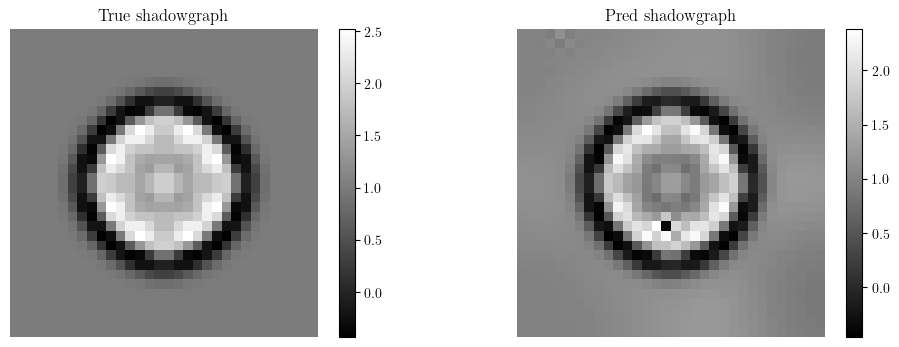

In [6]:
# Quick experiments with energy-based inverse problems on this linear operator

class RefractiveIndexModel(torch.nn.Module):
    def __init__(self, array_shape: tuple, A: np.ndarray, schlieren_image: np.ndarray, I0: float, c: float):
        super().__init__()
        # Initialise to zero
        #self.refractive_index_vol = torch.nn.Parameter(torch.tensor(np.zeros(array_shape), dtype=torch.float32))  # Unknown volume of refractive index
        # Initialise to random normal
        self.refractive_index_vol = torch.nn.Parameter(torch.tensor(np.random.randn(*array_shape), dtype=torch.float32))  # Unknown volume of refractive index
        self.linear_forward_model = torch.tensor(A, dtype=torch.float32)
        self.target = torch.tensor(schlieren_image, dtype=torch.float32)
        self.I0 = I0
        self.c = c
        self.Nx = array_shape[0]
        self.Ny = array_shape[1]

    def forward(self):
        n_vec = einops.rearrange(self.refractive_index_vol, 'i j k -> (i j k)')
        shadow_vec = self.I0 + self.c * self.linear_forward_model @ n_vec
        shadow_im = einops.rearrange(shadow_vec, '(Nx Ny) -> Nx Ny', Nx=self.Nx, Ny=self.Ny)
        return shadow_im


def tv_loss(vol: torch.Tensor):
    # Total variation regularization
    diff_x = vol[1:, :, :] - vol[:-1, :, :]
    diff_y = vol[:, 1:, :] - vol[:, :-1, :]
    diff_z = vol[:, :, 1:] - vol[:, :, :-1]
    return torch.sum(torch.abs(diff_x)) + torch.sum(torch.abs(diff_y)) + torch.sum(torch.abs(diff_z))


# Initialize model
target = shadow_im
model = RefractiveIndexModel((Nx, Ny, Nz), A, target, I0, c)
optimizer = optim.Adam([model.refractive_index_vol], lr=0.1)
lambda_tv = 0.001  # Regularization weight

# Optimization loop
n_iterations = 250
losses = []
for i in tqdm.tqdm(range(n_iterations), desc="Optimizing"):
    optimizer.zero_grad()

    output = model()
    data_loss = torch.sum((output - torch.tensor(target))**2)
    reg_loss = tv_loss(model.refractive_index_vol)

    loss = data_loss + lambda_tv * reg_loss
    loss.backward()
    losses.append(loss.item())
    optimizer.step()


plt.plot(losses)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
print(f'Final loss: {loss.item()}')
refractive_index_vol = model.refractive_index_vol.detach().numpy()

# Display slices from the original and solved volumes
slice_plot(spherical_shock_vol)
slice_plot(refractive_index_vol)

# Display the shadowgraphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("True shadowgraph")
im = plt.imshow(shadow_im, cmap='gray')
plt.colorbar(im)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Pred shadowgraph")
im = plt.imshow(output.detach().numpy(), cmap='gray')
plt.colorbar(im)
plt.axis('off')


Optimizing: 100%|██████████| 200/200 [00:01<00:00, 102.54it/s]


Final loss: 24.169637447746837


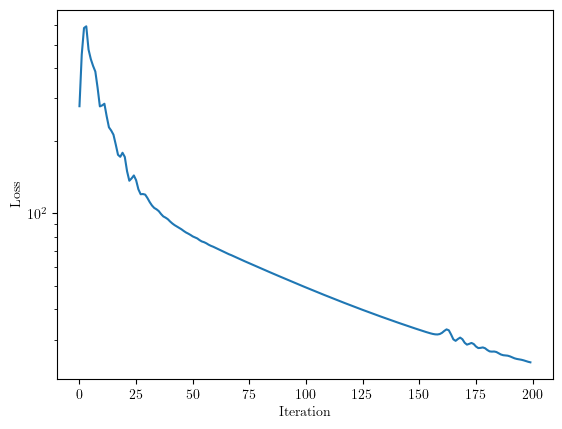

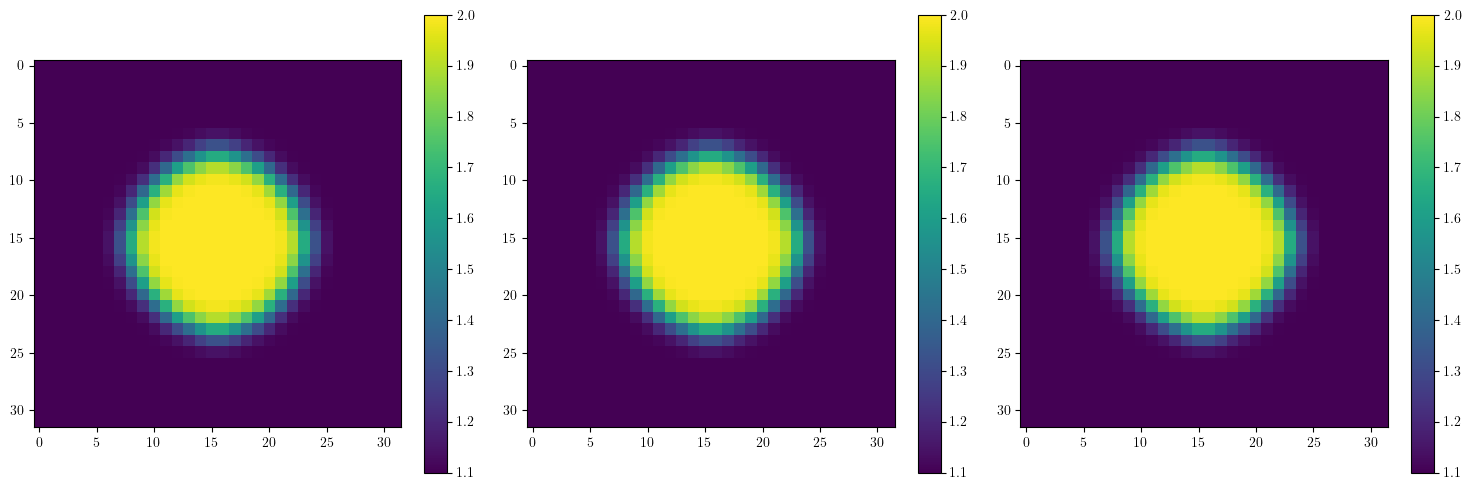

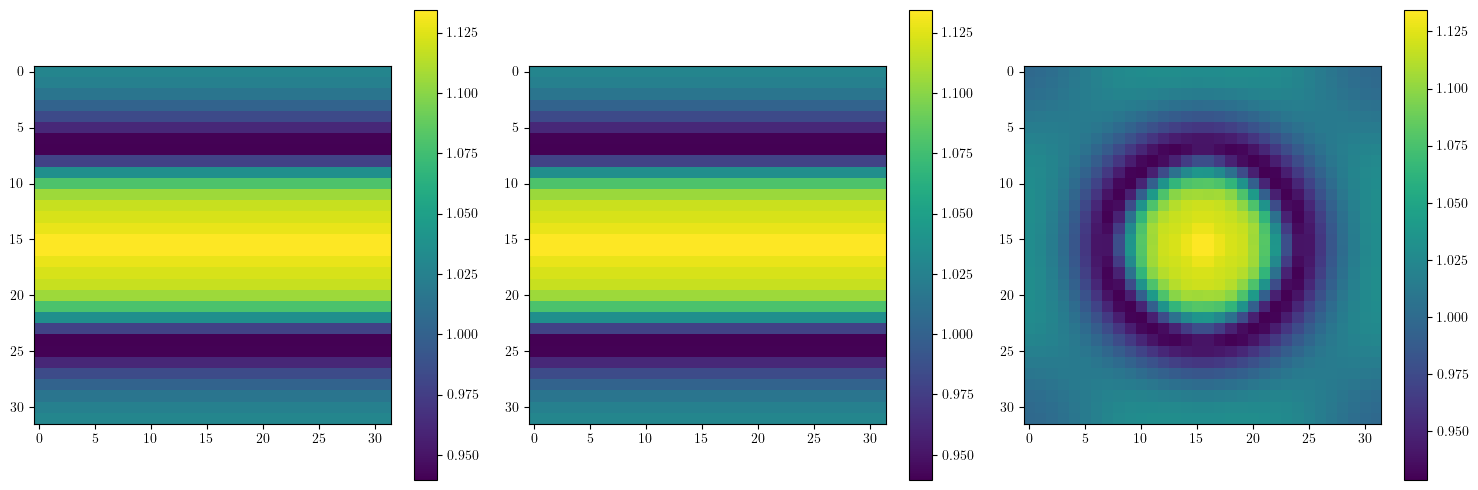

(-0.5, 31.5, 31.5, -0.5)

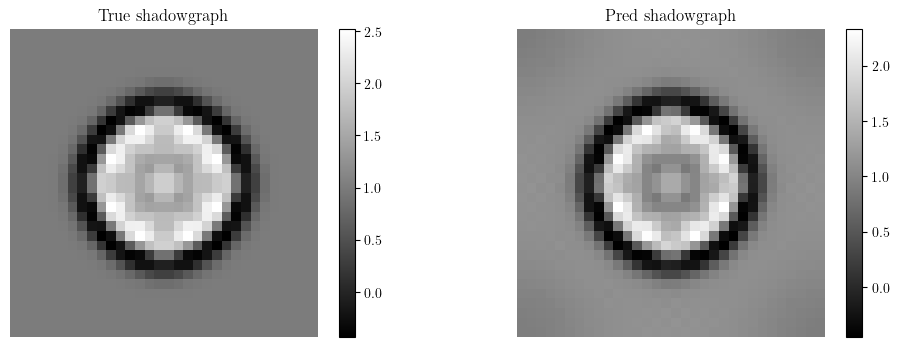

In [7]:
# Quick experiments with energy-based inverse problems on this linear operator

class RefractiveIndexModel(torch.nn.Module):
    def __init__(self, array_shape: tuple, A: np.ndarray, schlieren_image: np.ndarray, I0: float, c: float):
        super().__init__()
        # Initialise to zero
        self.refractive_index_vol = torch.nn.Parameter(torch.tensor(np.ones(array_shape), dtype=torch.float32))  # Unknown volume of refractive index
        # Initialise to random normal
        #self.refractive_index_vol = torch.nn.Parameter(torch.tensor(np.random.randn(*array_shape), dtype=torch.float32))  # Unknown volume of refractive index
        self.linear_forward_model = torch.tensor(A, dtype=torch.float32)
        self.target = torch.tensor(schlieren_image, dtype=torch.float32)
        self.I0 = I0
        self.c = c
        self.Nx = array_shape[0]
        self.Ny = array_shape[1]

    def forward(self):
        n_vec = einops.rearrange(self.refractive_index_vol, 'i j k -> (i j k)')
        shadow_vec = self.I0 + self.c * self.linear_forward_model @ n_vec
        shadow_im = einops.rearrange(shadow_vec, '(Nx Ny) -> Nx Ny', Nx=self.Nx, Ny=self.Ny)
        return shadow_im


def tv_loss(vol: torch.Tensor):
    # Total variation regularization
    diff_x = vol[1:, :, :] - vol[:-1, :, :]
    diff_y = vol[:, 1:, :] - vol[:, :-1, :]
    diff_z = vol[:, :, 1:] - vol[:, :, :-1]
    return torch.sum(torch.abs(diff_x)) + torch.sum(torch.abs(diff_y)) + torch.sum(torch.abs(diff_z))


# Initialize model
target = shadow_im
model = RefractiveIndexModel((Nx, Ny, Nz), A, target, I0, c)
optimizer = optim.Adam([model.refractive_index_vol], lr=0.01)
lambda_tv = 0.001  # Regularization weight

# Optimization loop
n_iterations = 200
losses = []
for i in tqdm.tqdm(range(n_iterations), desc="Optimizing"):
    optimizer.zero_grad()

    output = model()
    data_loss = torch.sum((output - torch.tensor(target))**2)
    reg_loss = tv_loss(model.refractive_index_vol)

    loss = data_loss + lambda_tv * reg_loss
    loss.backward()
    losses.append(loss.item())
    optimizer.step()


plt.plot(losses)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
print(f'Final loss: {loss.item()}')
refractive_index_vol = model.refractive_index_vol.detach().numpy()

# Display slices from the original and solved volumes
slice_plot(spherical_shock_vol)
slice_plot(refractive_index_vol)

# Display the shadowgraphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("True shadowgraph")
im = plt.imshow(shadow_im, cmap='gray')
plt.colorbar(im)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Pred shadowgraph")
im = plt.imshow(output.detach().numpy(), cmap='gray')
plt.colorbar(im)
plt.axis('off')
